# Adversarial Chess
6.4212 Final Project

Kameron Dawson

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    DiagramBuilder, StartMeshcat, Simulator, Rgba, RigidTransform
)
from pydrake.geometry import Sphere
from manipulation.station import LoadScenario, MakeHardwareStation, AddPointClouds
from manipulation.utils import RenderDiagram
from setup_simulation import get_scenario
from utils import visualize_box, visualize_text
from perception.point_cloud import get_scene_point_cloud, get_model_point_clouds
from perception.clustering import cluster_point_cloud_kmeans, cluster_point_cloud_dbscan, cluster_point_cloud_hybrid
from perception.perception import segment_scene_point_cloud, classify_piece_colors, match_scene_to_model_cloud_icp, match_scene_to_model_cloud_bb
from perception.axis import get_cloud_main_axis_pca

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Setup meshcat for visualization
meshcat = StartMeshcat()
print('Click the link above to open Meshcat in your browser!')

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


In [3]:
# Clear meshcat
meshcat.Delete()

In [4]:
# Get scenario
scenario_string = get_scenario()

# Load the scenario and build the simulation station
scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)

# Build a Drake Diagram containing the station
builder = DiagramBuilder()
builder.AddSystem(station)

# Setup getting point clouds from the cameras
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)
builder.ExportOutput(to_point_cloud["camera0"].get_output_port(), "camera0_point_cloud")
builder.ExportOutput(to_point_cloud["camera1"].get_output_port(), "camera1_point_cloud")
builder.ExportOutput(to_point_cloud["camera2"].get_output_port(), "camera2_point_cloud")

# Build diagram
diagram = builder.Build()

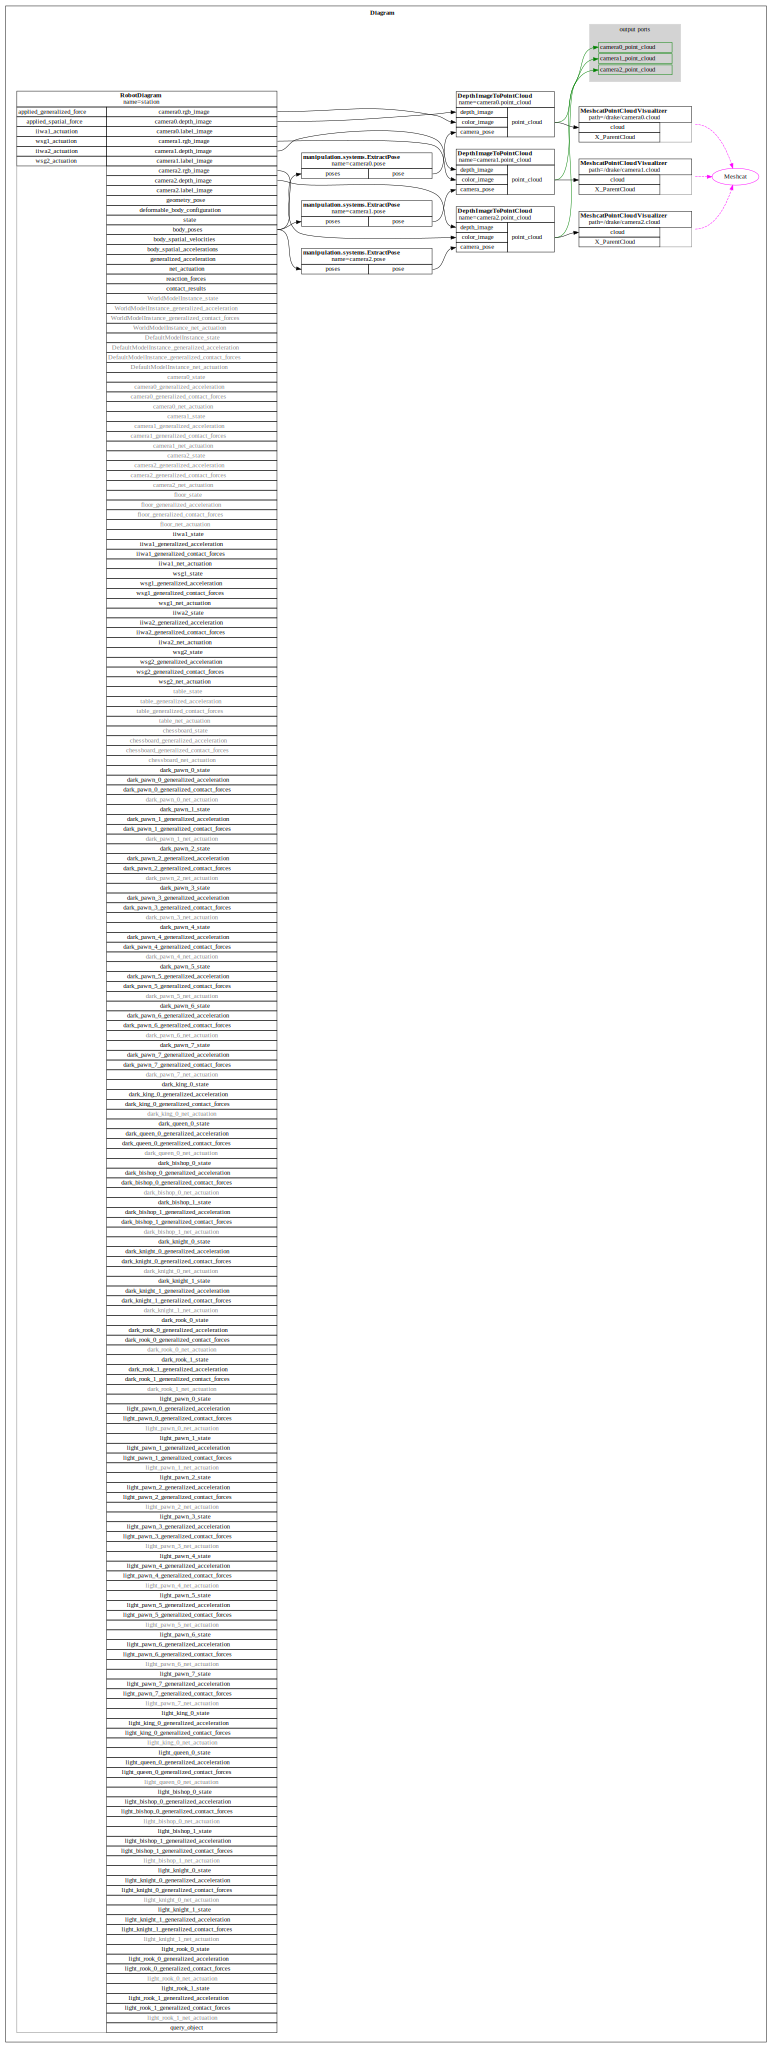

In [5]:
RenderDiagram(diagram, max_depth=1)

In [6]:
# Get relevant vars from the diagram
context = diagram.CreateDefaultContext()

In [7]:
# Create and run a simulator
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(0.1)

## Perception

### Sanity Checks

In [ ]:
# Run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1", "camera2"]
station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

plt.show()

In [ ]:
# Run the following cell to visualize the depth outputs of each of the cameras
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.depth_image").Eval(station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

plt.show()

### ICP

In [8]:
# Get scene point cloud from depth cameras, then segment it by cropping out known objects (floor, table, chessboard, iiwas)
scene_point_cloud = segment_scene_point_cloud(get_scene_point_cloud(diagram, context), 0.001)

In [9]:
# Sanity checks of scene point cloud
print('Num scene points: ', scene_point_cloud.size())
xyzs = scene_point_cloud.xyzs()
x = xyzs[0]
y = xyzs[1]
z = xyzs[2]

print('min, max xyz:')
min_x, max_x = min(x), max(x)
min_y, max_y = min(y), max(y)
min_z, max_z = min(z), max(z)
print(min_x, max_x)
print(min_y, max_y)
print(min_z, max_z)

Num scene points:  8591
min, max xyz:
-0.17744415 0.1799749
-0.1755087 0.17810935
0.5281069 0.5887327


In [ ]:
# Visualize scene point cloud
meshcat.SetObject(
    "scene_point_cloud", scene_point_cloud, point_size=0.05, rgba=Rgba(1, 0, 0)
)

In [10]:
# Scene point cloud only contains piece clouds
# piece_clouds = cluster_point_cloud_kmeans(scene_point_cloud)
# piece_clouds = cluster_point_cloud_dbscan(scene_point_cloud)
piece_clouds = cluster_point_cloud_hybrid(scene_point_cloud)

In [ ]:
# Visual piece cloud centroids
for i, piece_cloud in enumerate(piece_clouds):
    pts = piece_cloud.xyzs()
    centroid = np.mean(pts, axis=1)
    X = RigidTransform()
    X.set_translation(centroid)
    path = f'/piece/{i}'
    meshcat.SetTransform(path, X)
    meshcat.SetObject(
        path, Sphere(0.01), Rgba(0, 0, 1)
    )

In [ ]:
# Visualize piece clouds
for i, cluster in enumerate(piece_clouds):
    meshcat.SetObject(
        f"cluster_point_cloud_{i}", cluster, point_size=0.05, rgba=Rgba(1, 0, 0)
    )

In [11]:
# Separate piece clouds into the dark and light sets
color_classifications = classify_piece_colors(piece_clouds)
piece_clouds_by_color = {'dark': [], 'light': []}
for color, cluster in zip(color_classifications, piece_clouds):
    piece_clouds_by_color[color].append(cluster)
    

In [15]:
# Visualize color classified piece clouds
i = 0
for color, cluster in zip(color_classifications, piece_clouds):
    rgb = Rgba(1, 1, 1) if color == 'light' else Rgba(0, 0, 0)
    meshcat.SetObject(
        f"cluster_point_cloud_{color}_{i}", cluster, point_size=0.0025, rgba=rgb
    )
    i += 1

In [12]:
# Get model point clouds
model_point_clouds = get_model_point_clouds()

In [13]:
# Match scene clusters to model clouds using bounding boxes
dark_poses = match_scene_to_model_cloud_bb(piece_clouds_by_color['dark'], model_point_clouds['pieces']['dark'])
light_poses = match_scene_to_model_cloud_bb(piece_clouds_by_color['light'], model_point_clouds['pieces']['light'])

In [14]:
colors = {
    'pawn': Rgba(1, 0, 0), # red
    'king': Rgba(0, 1, 0), # green
    'queen': Rgba(0, 0, 1), # blue
    'bishop': Rgba(1, 1, 0), # yellow
    'knight': Rgba(0, 1, 1), # cyan
    'rook': Rgba(1, 0, 1) # magenta
}

for piece, cloud in zip(dark_poses, piece_clouds_by_color['dark']):
    name = piece[:-1]
    # Get piece pose
    pts = cloud.xyzs()
    centroid = np.mean(pts, axis=1)
    X = RigidTransform()
    X.set_translation(centroid)
    # Draw piece name
    # pose = RigidTransform()
    # pose.set_translation([centroid[0], centroid[1], 0.6])
    # visualize_text(meshcat, name, X, piece)
    # Visualize centroid
    path = f'/piece/{piece}'
    meshcat.SetTransform(path, X)
    meshcat.SetObject(
        path, Sphere(0.01), rgba=colors[name]
    )

In [16]:
for cloud in piece_clouds_by_color['dark']:
    pts = cloud.xyzs()
    x, y, z = pts[0], pts[1], pts[2]
    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)
    min_z, max_z = np.min(z), np.max(z)
    lower, upper = np.array([min_x, min_y, min_z]), np.array([max_x, max_y, max_z])
    visualize_box(meshcat, lower, upper)

In [ ]:
for i, cloud in enumerate(piece_clouds_by_color['dark']):
    main_axis = get_cloud_main_axis_pca(cloud)
    print(main_axis)
    meshcat.SetLine(f'line{i}', main_axis)

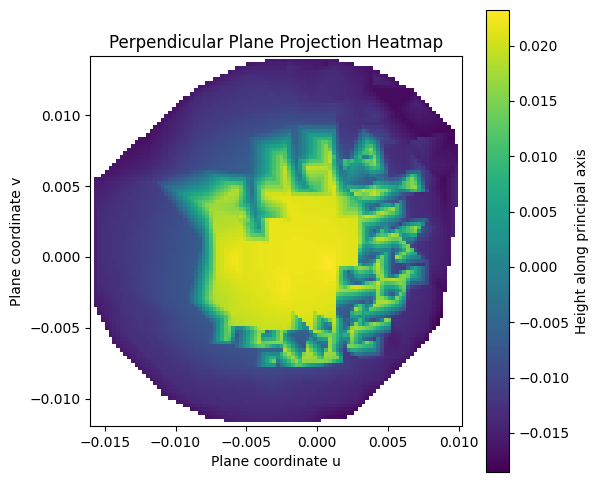

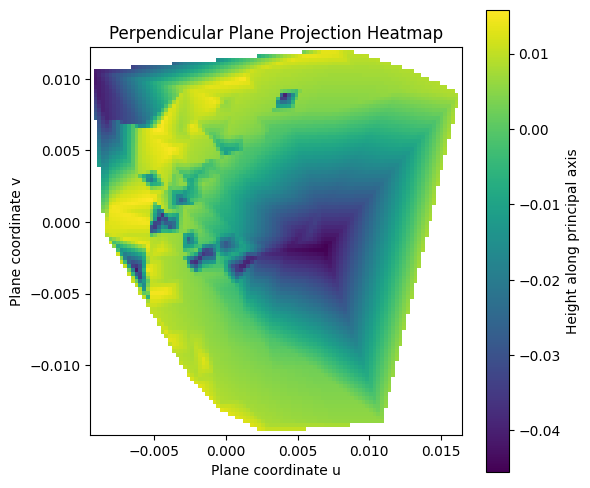

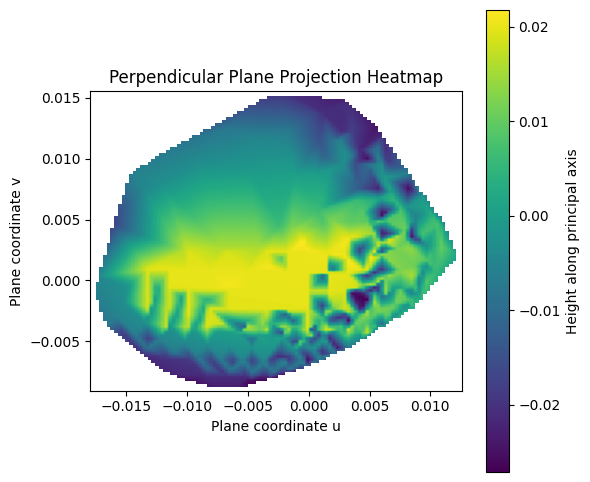

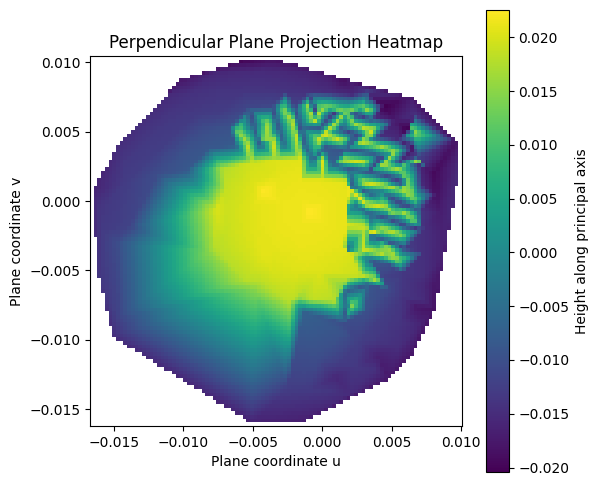

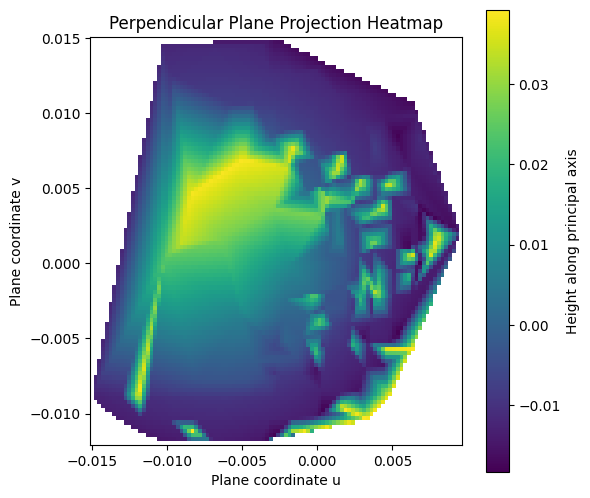

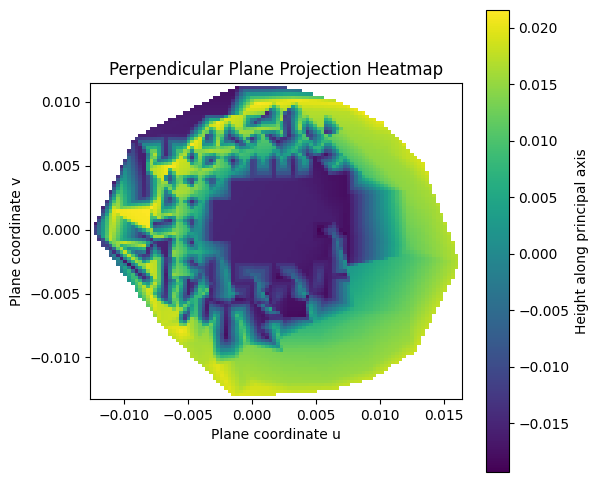

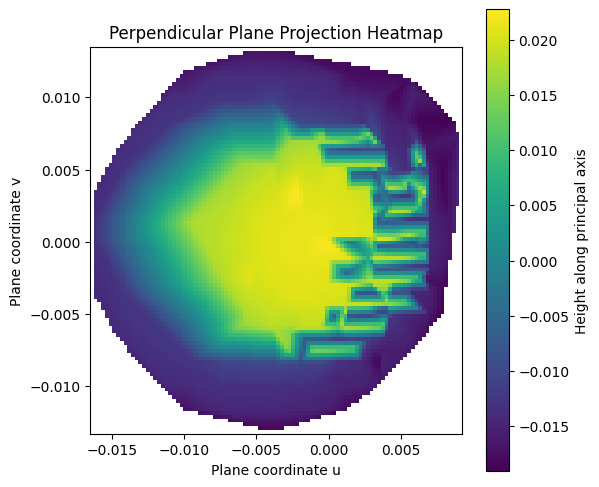

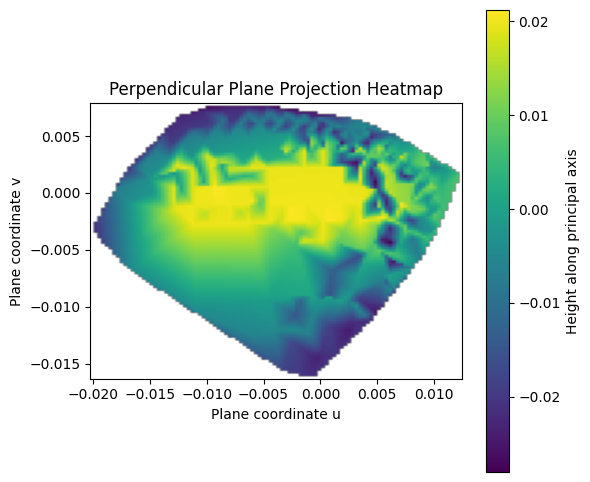

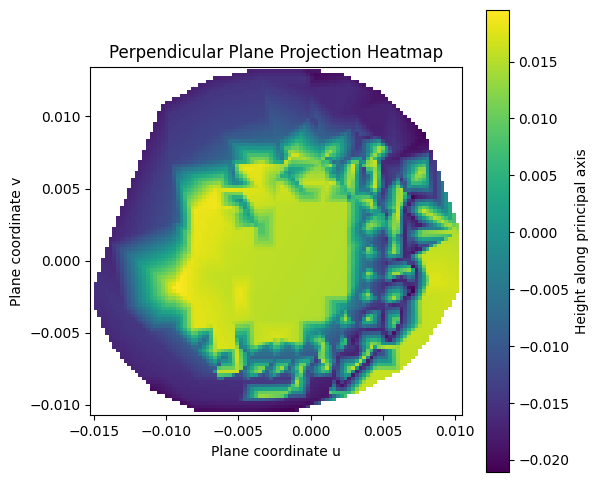

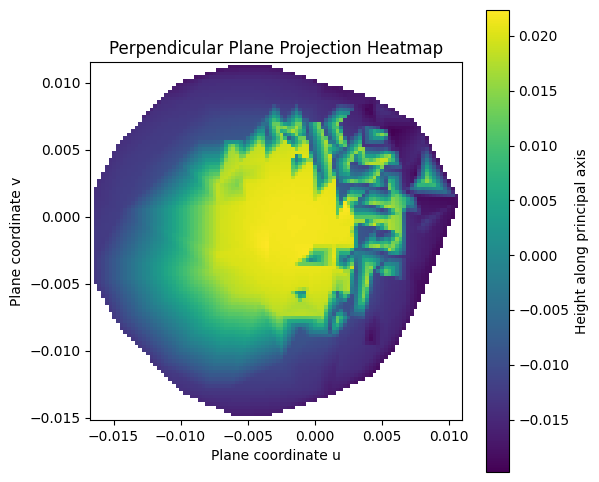

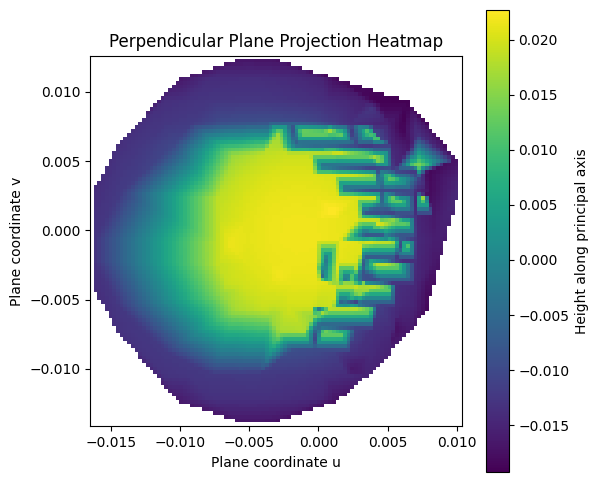

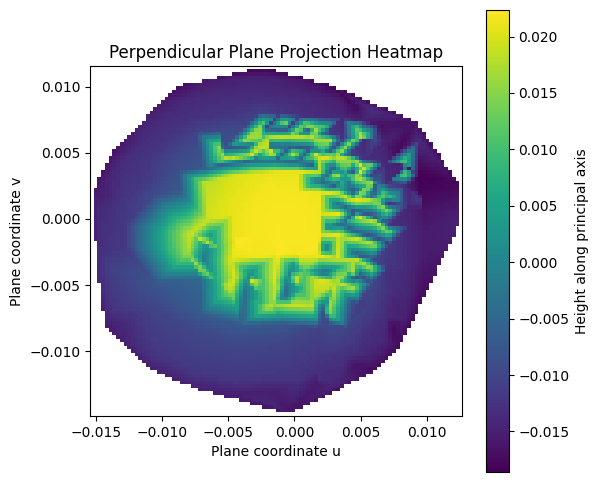

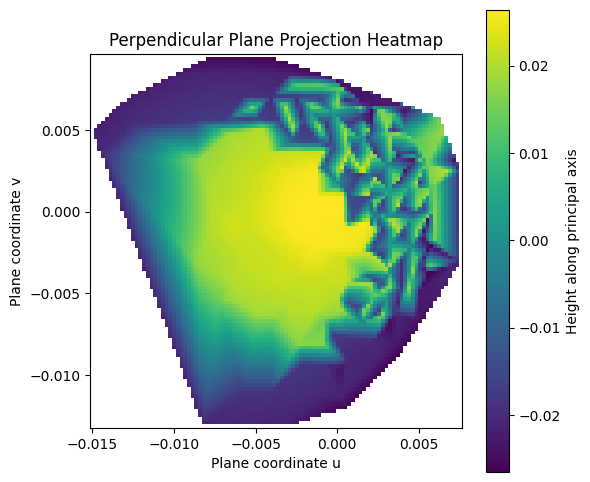

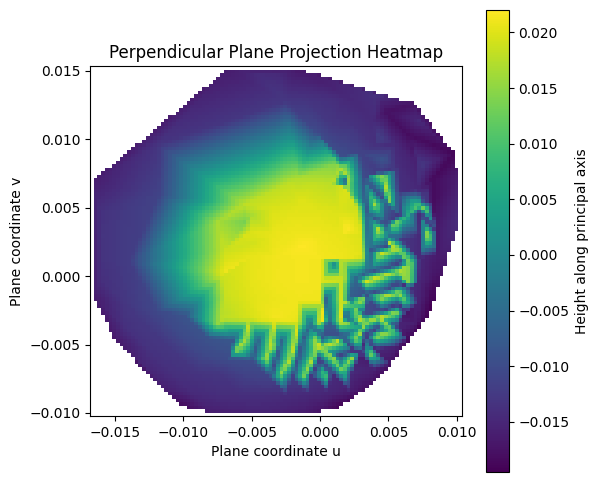

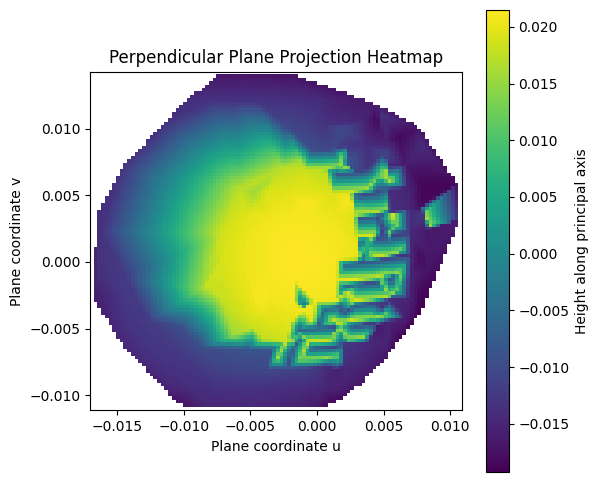

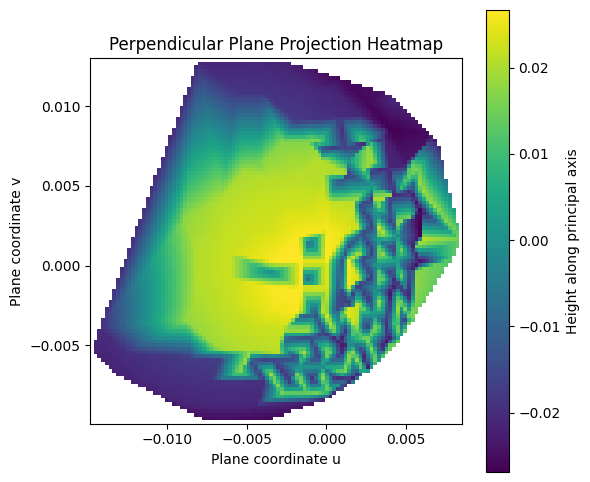

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def visualize_perpendicular_plane(point_cloud, main_axis, grid_res=100):
    """
    Projects a point cloud onto a plane perpendicular to main_axis and visualizes
    a heat map of the original z-axis (main_axis) values.

    Args:
        point_cloud: Drake PointCloud (3xN)
        main_axis: np.array(3,) unit vector along principal axis
        grid_res: resolution of the heatmap grid
    """
    pts = point_cloud.xyzs().T  # Nx3

    # Center the cloud
    centroid = np.mean(pts, axis=0)
    pts_centered = pts - centroid

    # Compute two perpendicular vectors to define the plane
    # Pick an arbitrary vector not parallel to main_axis
    arbitrary = np.array([1, 0, 0]) if abs(main_axis[0]) < 0.9 else np.array([0, 1, 0])
    u = np.cross(main_axis, arbitrary)
    u /= np.linalg.norm(u)
    v = np.cross(main_axis, u)
    v /= np.linalg.norm(v)

    # Project points onto the plane
    proj_coords_u = np.dot(pts_centered, u)
    proj_coords_v = np.dot(pts_centered, v)
    heights = np.dot(pts_centered, main_axis)  # height along main_axis

    # Create a grid for contour / heatmap
    grid_u = np.linspace(proj_coords_u.min(), proj_coords_u.max(), grid_res)
    grid_v = np.linspace(proj_coords_v.min(), proj_coords_v.max(), grid_res)
    grid_U, grid_V = np.meshgrid(grid_u, grid_v)

    # Interpolate heights onto the grid
    grid_H = griddata(
        points=np.stack([proj_coords_u, proj_coords_v], axis=1),
        values=heights,
        xi=(grid_U, grid_V),
        method='linear'
    )

    # Plot heatmap
    plt.figure(figsize=(6,6))
    plt.imshow(grid_H, extent=(grid_u.min(), grid_u.max(), grid_v.min(), grid_v.max()),
               origin='lower', cmap='viridis', aspect='equal')
    plt.colorbar(label='Height along principal axis')
    plt.xlabel('Plane coordinate u')
    plt.ylabel('Plane coordinate v')
    plt.title('Perpendicular Plane Projection Heatmap')
    plt.show()

for i, cloud in enumerate(piece_clouds_by_color['dark']):
    main_axis = get_cloud_main_axis_pca(cloud)
    visualize_perpendicular_plane(cloud, main_axis)

In [63]:
def get_cloud_main_axis_pca(point_cloud):
    pts = point_cloud.xyzs().T # Nx3

    # Center the cloud
    pts_centered = pts - np.mean(pts, axis=0)

    # Covariance matrix
    cov = np.cov(pts_centered, rowvar=False)

    # PCA: eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # The eigenvector with largest eigenvalue is the main axis (tallest direction)
    idx = np.argmax(eigenvalues)
    main_axis = eigenvectors[:, idx]

    return main_axis

def get_piece_cloud_main_axis(piece_cloud):
    # Get main axis
    main_axis = get_cloud_main_axis_pca(piece_cloud)

    # Calculate distance between main axis and x,y,z axes
    pos_main_axis = np.abs(main_axis)
    x_axis, y_axis, z_axis = np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])
    x_dist = np.linalg.norm(pos_main_axis - x_axis)
    y_dist = np.linalg.norm(pos_main_axis - y_axis)
    z_dist = np.linalg.norm(pos_main_axis - z_axis)

    # Determine if it's upright based on which axis it is closer to
    upright = z_dist <= x_dist and z_dist <= y_dist

    # Determine direction of main axis
    z = main_axis[2]
    if upright:
        # If it's closer to being upright base is likely at the bottom of the main axis
        if z < 0:
            # Flip
            main_axis = -main_axis
    else:
        # If it's on its side likely base is pointing up
        if z > 0:
            # Flip
            main_axis = -main_axis
    return main_axis


for i, cloud in enumerate(piece_clouds_by_color['dark']):
    main_axis = get_piece_cloud_main_axis(cloud)
    print(main_axis)
    # break

[-0.02277913 -0.07016544  0.99727525]
[ 0.08703941 -0.15540844  0.98400831]
[-0.11125046 -0.11747185  0.98682506]
[ 0.06978104 -0.09664396  0.99286986]
[-0.07799141 -0.05246698  0.99557248]
[ 0.0757118  -0.1128957   0.99071806]
[-0.01175655 -0.09855602  0.99506206]
[ 0.11907176 -0.12311498  0.98522313]
[-0.06813514 -0.1200093   0.99043191]
[ 0.04173333 -0.10533122  0.9935611 ]
[ 0.01394922 -0.09693294  0.99519316]
[ 0.0445936  -0.06855756  0.99665002]
[ 0.04578415 -0.10546892  0.99336807]
[-0.0641486  -0.09586014  0.99332562]
[-0.03123347 -0.10054969  0.99444167]
[-0.04987263 -0.09312147  0.9944049 ]
